In [1]:
import pandas as pd
df_instances = pd.read_parquet('/data/sample.K5M3.instances.parquet')

df_instances = df_instances.merge(
    pd.DataFrame(df_instances['key'].str.split(':').str[1:4].values.tolist(),
                 columns=['pois', 'sensors', 'sinks']).astype(int),
    left_index=True, right_index=True
)

print(sorted(df_instances['sensors'].unique()))

df_instances[
#     (df_instances['pois'] == 10)
#   & 
    (df_instances['sensors'] == 125)
#   & 
#     (df_instances['sinks'] == 1)
]

[25, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500]


,key,random_seed,instance,pois,sensors,sinks
3414,KCMC:50:125:12:700:100:100,90116672,KCMC;50 125 12;700 100 100;90116672;PS;0 6;0 2...,50,125,12
3415,KCMC:50:125:12:700:100:100,144123629,KCMC;50 125 12;700 100 100;144123629;PS;0 1;0 ...,50,125,12
3416,KCMC:50:125:12:700:100:100,249563921,KCMC;50 125 12;700 100 100;249563921;PS;0 13;0...,50,125,12
3417,KCMC:50:125:12:700:100:100,257105030,KCMC;50 125 12;700 100 100;257105030;PS;0 1;0 ...,50,125,12
3418,KCMC:50:125:12:700:100:100,345736707,KCMC;50 125 12;700 100 100;345736707;PS;0 50;0...,50,125,12
...,...,...,...,...,...,...
3641,KCMC:50:125:6:700:100:50,823626101,KCMC;50 125 6;700 100 50;823626101;PS;0 0;0 25...,50,125,6
3642,KCMC:50:125:6:700:100:50,912465122,KCMC;50 125 6;700 100 50;912465122;PS;0 16;0 4...,50,125,6
3643,KCMC:50:125:6:700:100:50,926253250,KCMC;50 125 6;700 100 50;926253250;PS;0 5;0 10...,50,125,6
3644,KCMC:50:125:6:700:100:50,948346184,KCMC;50 125 6;700 100 50;948346184;PS;0 3;0 17...,50,125,6


### Imports

In [2]:
import pandas as pd

from collections import Counter
from tqdm.notebook import tqdm

def degree_bins(degrees_dict):
    return dict(Counter([(str(d) if d < 10 else '10+') for d in degrees_dict.values()]))

import gurobipy as gp
from gurobipy import GRB

from kcmc_instance import KCMC_Instance

## Constants & Sample Instance

In [3]:
K=5
M=3

# Get a sample instance from the provided dataset
df_instances = pd.read_parquet('/data/sample.K5M3.instances.parquet')

serialized_instance = df_instances.iloc[300]['instance']   # KCMC:10:25:1:313:100:100
serialized_instance = df_instances.iloc[500]['instance']   # KCMC:10:50:1:443:100:100
serialized_instance = df_instances.iloc[2300]['instance']  # KCMC:30:75:1:542:100:100
serialized_instance = df_instances.iloc[0]['instance']     # KCMC:10:100:10:626:100:100
# serialized_instance = df_instances.iloc[3414]['instance']  # KCMC:50:125:12:700:100:100

# serialized_instance = df_instances.iloc[550]['instance']
# serialized_instance = df_instances.iloc[600]['instance']
# serialized_instance = df_instances.iloc[3921]['instance']  # 500 nodes 1 sinks
# # serialized_instance = df_instances.iloc[-2]['instance']  # 500 nodes 50 sinks

print('SERIALIZED INSTANCE:', serialized_instance[:20], '...')

# De-Serialize the instance as a KCMC_Instance object.
# It MIGHT be multisink and thus incompatible with the ILP formulation
maybe_multisink_instance = KCMC_Instance(serialized_instance, False, True, True)
print('MAYBE MULTISINK INSTANCE:', maybe_multisink_instance)
print('\tdegrees:\n\tPOIs:', degree_bins(maybe_multisink_instance.poi_degree),
      '\n\tSensors:', degree_bins(maybe_multisink_instance.sensor_degree),
      '\n\tSinks:', degree_bins(maybe_multisink_instance.sink_degree))


# Convert the instance to a single-sink version.
# Use M as the MAX_M parameter for minimal impact on performance
instance = maybe_multisink_instance.to_single_sink(MAX_M=M)
print('DEFINITELY SINGLE-SINK INSTANCE:', instance)
print('\tdegrees:\n\tPOIs:', degree_bins(instance.poi_degree),
      '\n\tSensors:', degree_bins(instance.sensor_degree),
      '\n\tSinks:', degree_bins(instance.sink_degree))

# Extract the component sets
iC = instance.inverse_coverage_graph
L = [str(m) for m in range(M)]
P = instance.pois
I = instance.sensors
S = instance.sinks
s = list(S)[0]  # HARD-CODED ASSUMPTION OF SINGLE-SINK!
A_c = instance.poi_edges
A_s = instance.sink_edges
A_g = instance.sensor_edges
A = A_c + A_g + A_s

SERIALIZED INSTANCE: KCMC;10 100 10;626 1 ...
MAYBE MULTISINK INSTANCE: <KCMC_0.1:10:100:10:626:100:100 16262359 [0]>
	degrees:
	POIs: {'9': 2, '7': 4, '10+': 1, '6': 1, '8': 1, '5': 1} 
	Sensors: {'10+': 36, '2': 7, '5': 7, '3': 2, '7': 9, '8': 10, '9': 5, '4': 6, '6': 5, '1': 4} 
	Sinks: {'6': 1, '9': 2, '10+': 3, '5': 3, '1': 1}
DEFINITELY SINGLE-SINK INSTANCE: <KCMC_1.0:10:130:1:626:100:100 16262359 [30]>
	degrees:
	POIs: {'9': 2, '7': 4, '10+': 1, '6': 1, '8': 1, '5': 1} 
	Sensors: {'10+': 53, '8': 6, '2': 7, '9': 9, '5': 16, '3': 2, '6': 7, '7': 8, '4': 6, '1': 7} 
	Sinks: {'10+': 1}


### Inspect instances
- GREEN: POIs
- RED: Sensor installation spots
- Black: Sinks
- Grey: Virtual-Sinks (similar to sensors)

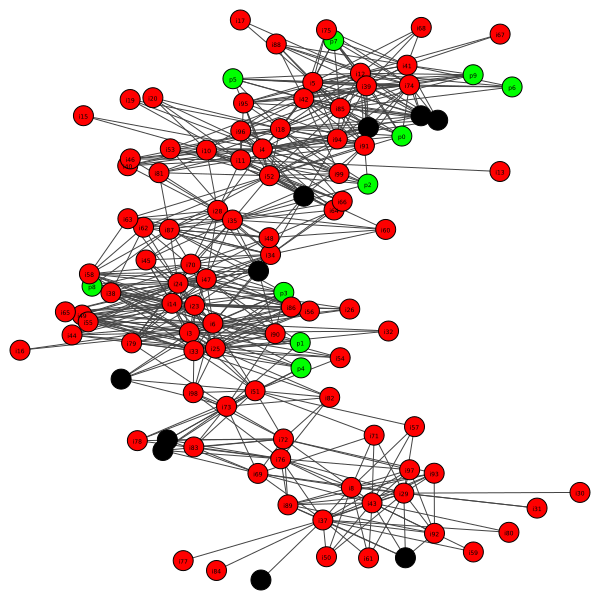

In [4]:
# Inspect the MULTISINK instance
maybe_multisink_instance.plot(labels=True)

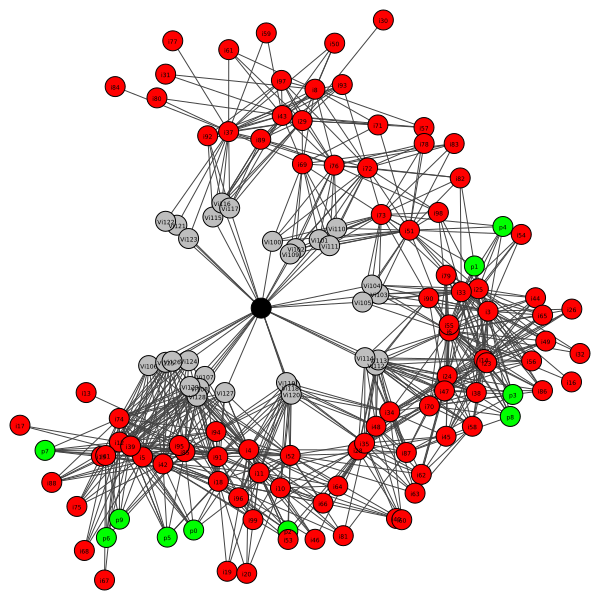

In [5]:
# Inspect the SINGLE-SINK instance
instance.plot(labels=True)

## GUROBI Model Object

In [6]:
# Start the GUROBI model
print('\n\nGUROBI:')
model = gp.Model('KCMC')

# Set the Time Limit and the Thread Count
model.setParam(GRB.Param.TimeLimit, 60.0)
model.setParam(GRB.Param.Threads, 1)



GUROBI:
[client] info  : Using libcurl/7.76.1 OpenSSL/1.1.1k
[client] info  : Default certificate path is /etc/ssl/certs/ca-certificates.crt
[client] info  : No HTTPS proxy
[client] info  : No HTTP proxy
[client] info  : Validate web license token a8303126-6090-4ba6-9156-d0ad82b20434 for container cc597115d57941ccf0e9117f1309800d9e5ef2be4695a9d032c7bec1f87fb6dc
[client] error : Web license token expired
[client] info  : Request web license token for container cc597115d57941ccf0e9117f1309800d9e5ef2be4695a9d032c7bec1f87fb6dc
[client] verb  : Web license token spec {"containerId": "cc597115d57941ccf0e9117f1309800d9e5ef2be4695a9d032c7bec1f87fb6dc", "licenseId": "661068", "cores": 4, "duration": 0, "version": "9.1.2"}
[client] verb  : POST https://token.gurobi.com/api/v1/tokens -->
[client] info  : POST https://token.gurobi.com/api/v1/tokens 201 0 943.53ms 153 1052 50846
[client] info  : Validate web license token 6ed93761-de46-4b12-93a1-1d9216180775 for container cc597115d57941ccf0e9117f

## ILP Variables

### $\mathbf{X}$ Variable
- Sets INSTALLED sensors apart from UNINSTALLED sensors.
- 1 = Installed, 0 = Uninstalled. Thus, $\mathbf{X}$ is a strictly binary variable.
- 2D-Array $[I \times L]$
    - $I$ is the Installation Spots array, that contains the sink and all Virtual Sinks
    - $L$ is the M-Forest array, containing all integers in the interval $[1 \dots M]$
    - $L$ is used because an installation spot can be a part of at most 1 Steiner Tree, but exactly which one is not known apriori
- The objective results will be derived from the state of this variable

In [7]:
X = model.addVars(I, L, vtype=GRB.BINARY, name="x")

### $\mathbf{Y}$ Variable
- Sets PARTICIPANT edges apart from NON-PARTICIPANT edges.
- 1 = participant, 0 = non-participant. Thus, $\mathbf{Y}$ is a strictly binary variable.
- 4D-Array $[A \times P \times L]$. 
    - $A$ is a 2D-Array since it contains all edges. Each edge is DUAL, so its reverse is also included in $A$. This is a problem because in our homogeneous sensor context each edge assumes its inverse, and our formulation assumes this. An restriction preventing the usage of an edge and its inverse will have to be added
    - $P$ is the POIs array
    - $L$ is the M-Forest array
    - An edge can only be a part of one Steiner Tree starting at a given POI, thus we have to consider the possibility that the edge belongs to any of the $L$ trees starting at any one of the $P$ POIs. 

In [8]:
Y = model.addVars(A, P, L, vtype=GRB.BINARY, name='y')

## Objective Function

- Very simple - the sum of all the elements in the $\mathbf{X}$ variable-array must be minimized. 

In [9]:
model.setObjective(X.sum('*', '*'), GRB.MINIMIZE)

## Constraints

### Unidirected Edges
- Either an edge or its inverse can be used, but not both. 
- Not every edge has to be used.
- We would rather not use this restriction since it is a performance penalty, but we were not able to avoid it in our implementation of the ILP formulation.

In [10]:
# unidirected_edges = model.addConstrs(
#     ((Y.sum(i, j, '*', '*') + Y.sum(j, i, '*', '*')) <= 1
#      for i, j in A),
#     name="ilp_multi_unidirected_edges"
# )

### Disjunction
- An instalation spot with an installed sensor may belong to a single Steiner Tree, regardless of the POIs it serves.

In [11]:
disjunction = model.addConstrs(
    (X.sum(i, '*') <= 1
     for i in I),
    name="ilp_multi_disjunction"
)

### Flow

- For any given POI $p \in P$ and (the) SINK $s \in S$
    - For any VERTICE $v \in P \bigcup I \bigcup S$
        - The sum of PARTICIPANT edges in the $l$-th Steiner Tree ($l \in L$) started in POI $p$ that LEAVE $v$, minus the sum of those that ARRIVE at $v$ must be equal to:
            - $1$ if $v=p$
            - $-1$ if $v=s$
            - 0 otherwise
- That is to say, the flow that leaves each vertex in each Steiner Tree is 1 if the vertex is a POI, -1 if it is a (the) sink and 0 otherwise

In [12]:
ilp_multi_flow_p = model.addConstrs(
    ((  gp.quicksum(Y.select(p, '*', p, l))
      - gp.quicksum(Y.select('*', p, p, l))) == 1
     for p in P
     for l in L),
    name="ilp_multi_flow_p"
)


ilp_multi_flow_s = model.addConstrs(
    ((  gp.quicksum(Y.select(s, '*', p, l))
      - gp.quicksum(Y.select('*', s, p, l))) == -1
     for p in P
     for l in L),
    name="ilp_multi_flow_s"
)


ilp_multi_flow_i = model.addConstrs(
    ((  gp.quicksum(Y.select(i, '*', p, l))
      - gp.quicksum(Y.select('*', i, p, l))) == 0
     for i in I
     for p in P
     for l in L),
    name="ilp_multi_flow_i"
)

### Projection
- Only relationship between Y and X
- For an edge (starting in a sensor) to participate in any Steiner Tree, its origin sensor must be installed in that tree

In [13]:
ilp_multi_projection = model.addConstrs(
    (Y.sum(i, '*', p, l) <= X.sum(i, l)
     for i in I
     for p in P
     for l in L),
    name="ilp_multi_projection"
)

### K-Coverage

- Every POI must be covered by at least K different installed sensors

In [14]:
ilp_multi_k_coverage = model.addConstrs(
    (gp.quicksum(X.select(iC[p], '*')) >= K
     for p in P),
    name="ilp_multi_k_coverage"
)

## Runtime

- Execute the model optimization.
- Unfeasible conclusions means that the WSN instance is NOT certified for K and M!

In [15]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 1 threads
[client] info  : Validate web license token 6ed93761-de46-4b12-93a1-1d9216180775 for container cc597115d57941ccf0e9117f1309800d9e5ef2be4695a9d032c7bec1f87fb6dc
Academic license - for non-commercial use only - registered to josefrf@ufmg.br
[client] info  : Web license token valid
Optimize a model with 7451 rows, 42483 columns and 126249 nonzeros
Model fingerprint: 0x90d07d12
Variable types: 0 continuous, 42483 integer (42483 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 337 rows and 1689 columns
Presolve time: 0.24s
Presolved: 7114 rows, 40794 columns, 123609 nonzeros
Variable types: 0 continuous, 40794 integer (40794 binary)

Root relaxation: objective 2.100000e+01, 9474 iterations, 2.20 seconds

    Nodes    |    Curr

In [16]:
# PARSE THE INSTALLATION
installation = {}
for x in X:
    installation_spot_id, steiner_tree_id = x
    sensor_installed = bool(X[x].X)
    if sensor_installed:
        installation[installation_spot_id] = steiner_tree_id
        print('Sensor installed in spot [', installation_spot_id,
              '] as a node in Steiner Tree [', steiner_tree_id, ']')

# CHECK THE USED SPOTS IN THE INSTALLATION
used_spots = [s for s, i in installation.items() if i is not None]
print('\n[', len(used_spots), '] sensors installed of [',
      instance.num_sensors, '] possible -',
      round(100*len(used_spots)/instance.num_sensors, 3), '%')

# FIND THE INSTALLATION IN THE ORIGINAL MULTISINK INSTANCE
original_installation = {
    instance.virtual_sinks_dict.get(s, s): t for s, t in installation.items()
}

# CHECK THE USED SPOTS IN THE INSTALLATION IN THE ORIGINAL MULTISINK INSTANCE
original_used_spots = [s for s, i in original_installation.items() if i is not None]
print('\n[', len(original_used_spots), '] ORIGINAL sensors+sinks installed of [',
      maybe_multisink_instance.num_sensors, '] possible -',
      round(100*len(original_used_spots)/maybe_multisink_instance.num_sensors, 3), '%')

original_installation

Sensor installed in spot [ i3 ] as a node in Steiner Tree [ 0 ]
Sensor installed in spot [ i4 ] as a node in Steiner Tree [ 2 ]
Sensor installed in spot [ i6 ] as a node in Steiner Tree [ 1 ]
Sensor installed in spot [ i12 ] as a node in Steiner Tree [ 1 ]
Sensor installed in spot [ i24 ] as a node in Steiner Tree [ 2 ]
Sensor installed in spot [ i25 ] as a node in Steiner Tree [ 0 ]
Sensor installed in spot [ i33 ] as a node in Steiner Tree [ 2 ]
Sensor installed in spot [ i35 ] as a node in Steiner Tree [ 1 ]
Sensor installed in spot [ i39 ] as a node in Steiner Tree [ 0 ]
Sensor installed in spot [ i41 ] as a node in Steiner Tree [ 1 ]
Sensor installed in spot [ i47 ] as a node in Steiner Tree [ 1 ]
Sensor installed in spot [ i51 ] as a node in Steiner Tree [ 1 ]
Sensor installed in spot [ i52 ] as a node in Steiner Tree [ 2 ]
Sensor installed in spot [ i74 ] as a node in Steiner Tree [ 2 ]
Sensor installed in spot [ i85 ] as a node in Steiner Tree [ 2 ]
Sensor installed in spot [ i

{'i3': '0',
 'i4': '2',
 'i6': '1',
 'i12': '1',
 'i24': '2',
 'i25': '0',
 'i33': '2',
 'i35': '1',
 'i39': '0',
 'i41': '1',
 'i47': '1',
 'i51': '1',
 'i52': '2',
 'i74': '2',
 'i85': '2',
 'i87': '2',
 'i91': '1',
 'i96': '0',
 's1': '0',
 's6': '2'}

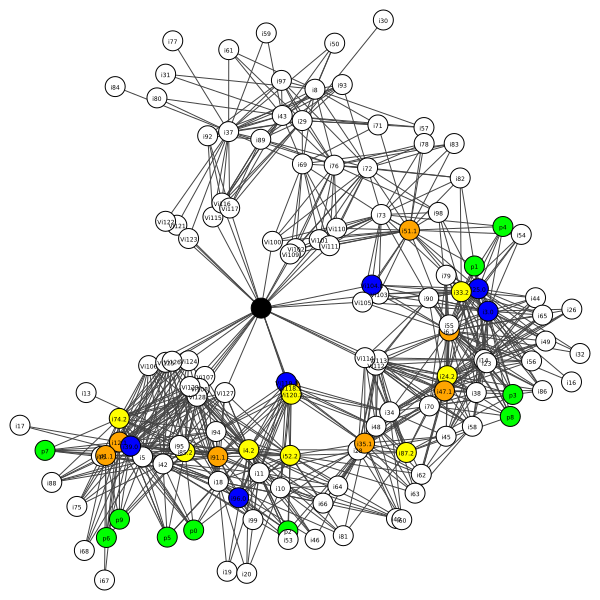

In [17]:
instance.plot(labels=True, installation=installation)

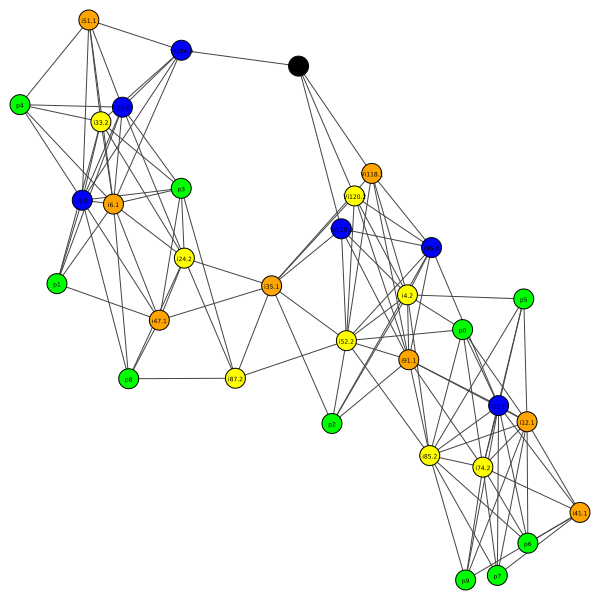

In [18]:
instance.plot(labels=True, installation=installation, minimal=True)